# 공식 베이스 라인 LGBM

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pathlib import Path
import random
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from pathlib import Path
import seaborn as sns
import lightgbm
import warnings
from matplotlib import pyplot as plt
from matplotlib import rcParams
warnings.filterwarnings("ignore")

In [15]:
rcParams['figure.figsize'] = (32, 16)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [3]:
train= pd.read_csv("data/train/train.csv")

In [4]:
submission = pd.read_csv('data/sample_submission.csv')

In [5]:
train

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0
...,...,...,...,...,...,...,...,...,...
52555,1094,21,30,0,0,2.4,70.70,-4,0.0
52556,1094,22,0,0,0,2.4,66.79,-4,0.0
52557,1094,22,30,0,0,2.2,66.78,-4,0.0
52558,1094,23,0,0,0,2.1,67.72,-4,0.0


<AxesSubplot:>

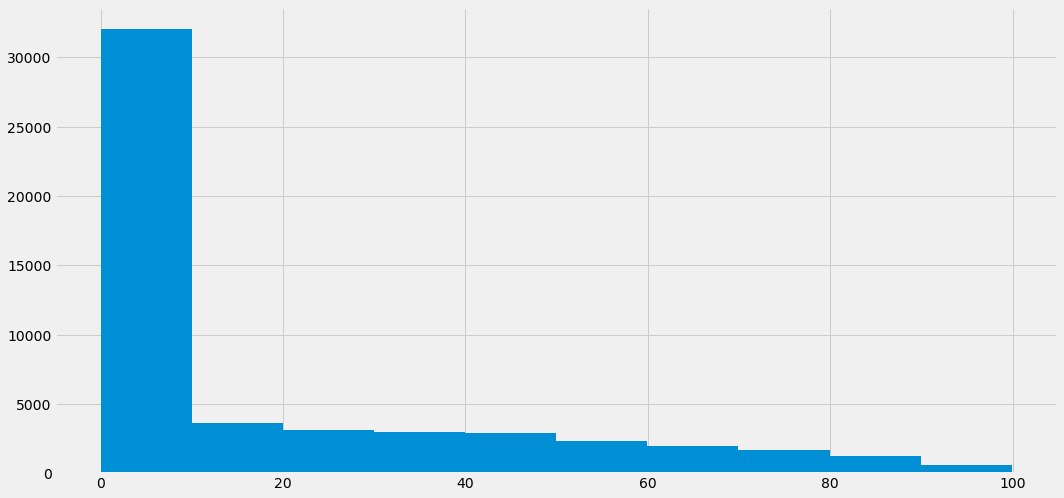

In [6]:
train['TARGET'].hist()

<AxesSubplot:>

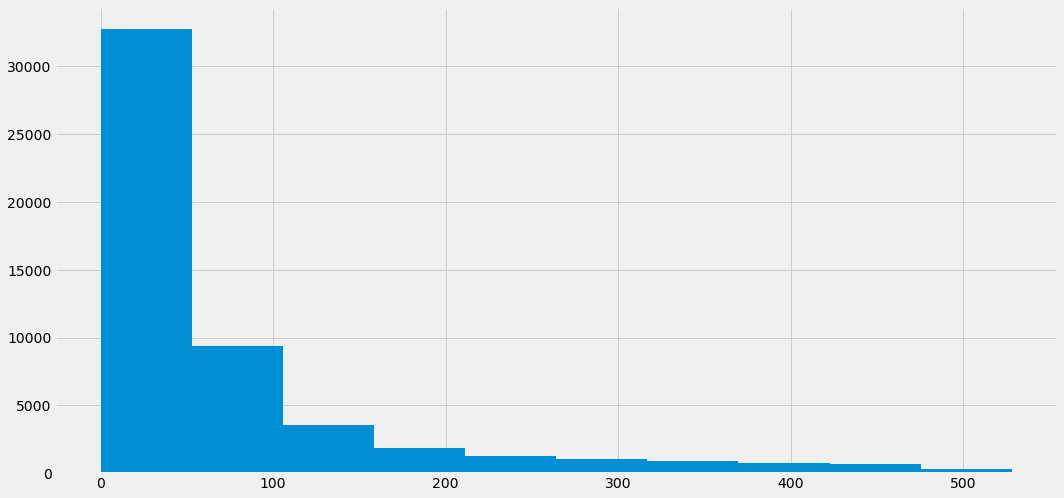

In [7]:
train['DHI'].hist()

<AxesSubplot:>

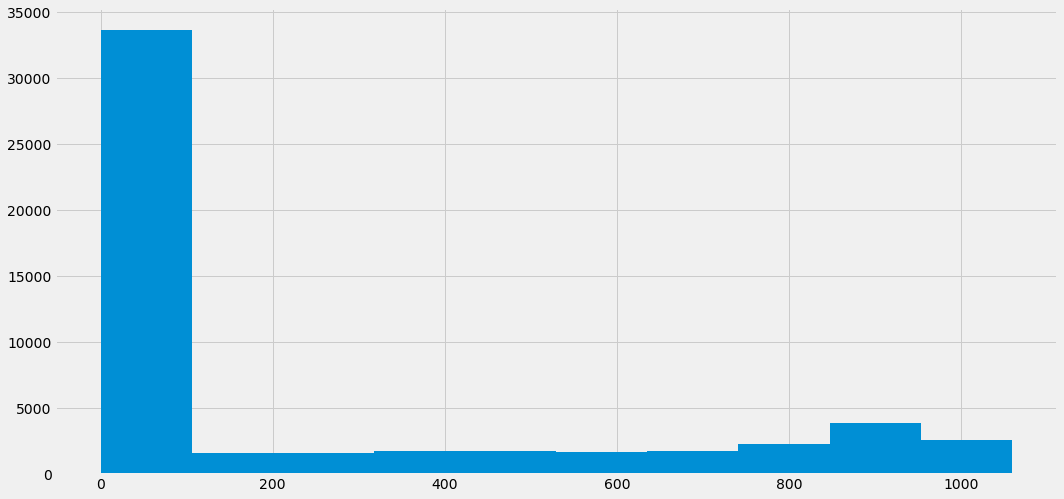

In [8]:
train['DNI'].hist()

<AxesSubplot:>

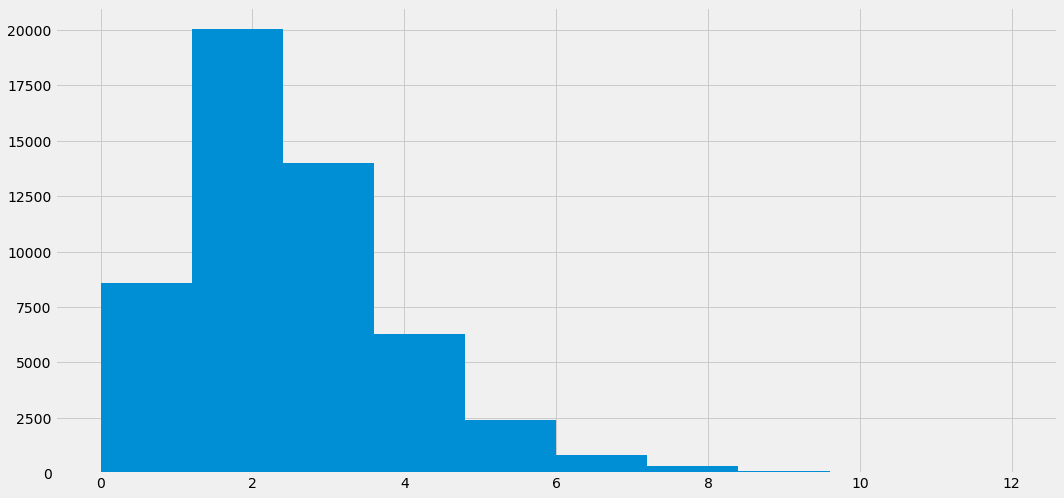

In [9]:
train['WS'].hist()

<AxesSubplot:>

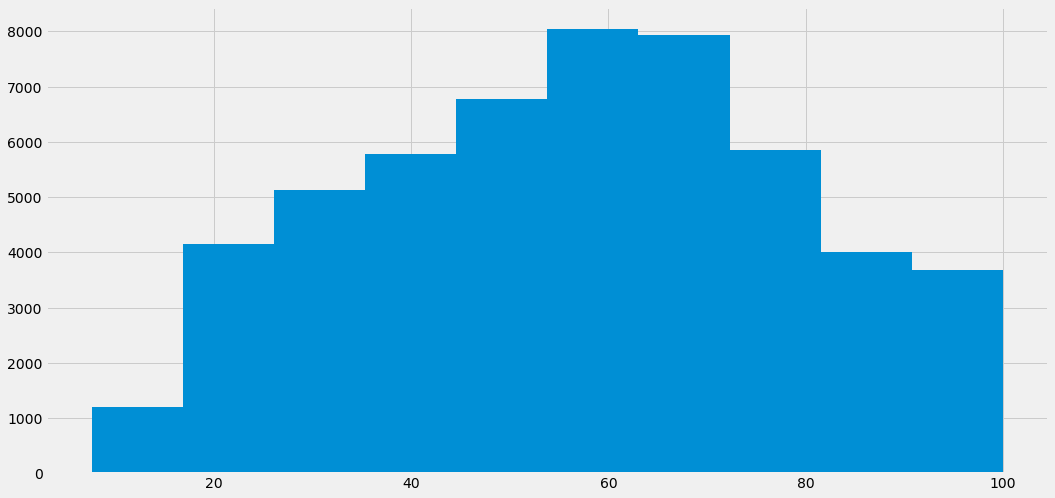

In [10]:
train['RH'].hist()

<AxesSubplot:>

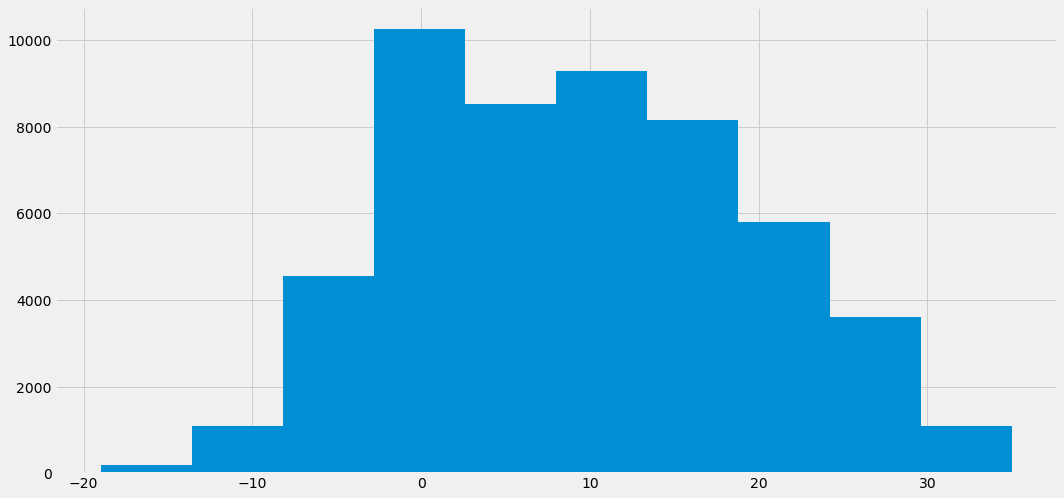

In [11]:
train['T'].hist()

In [12]:
plt.text

<function matplotlib.pyplot.text(x, y, s, fontdict=None, **kwargs)>

In [13]:
train.corr().style.background_gradient()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
Day,1.0000,0.0000,0.0000,-0.0278,0.0219,0.0385,-0.1277,0.0729,-0.0025
Hour,0.0000,1.0000,0.0000,0.0299,-0.0181,-0.0559,-0.0843,0.1055,0.0038
Minute,0.0000,0.0000,1.0000,-0.0013,-0.0010,-0.0095,0.0088,-0.0076,-0.0002
DHI,-0.0278,0.0299,-0.0013,1.0000,0.2883,0.2033,-0.4785,0.4578,0.6669
DNI,0.0219,-0.0181,-0.0010,0.2883,1.0000,0.2196,-0.6112,0.4025,0.8335
WS,0.0385,-0.0559,-0.0095,0.2033,0.2196,1.0000,-0.2300,0.0277,0.2385
RH,-0.1277,-0.0843,0.0088,-0.4785,-0.6112,-0.2300,1.0000,-0.5328,-0.6772
T,0.0729,0.1055,-0.0076,0.4578,0.4025,0.0277,-0.5328,1.0000,0.5620
TARGET,-0.0025,0.0038,-0.0002,0.6669,0.8335,0.2385,-0.6772,0.5620,1.0000


In [ ]:
train.groupby('TARGET').mean().T.plot(kind='barh')

<AxesSubplot:>

## 전처리

이 부분 함수는 아마도 
- train 데이터인 경우 [Hour	TARGET_lag_48	DHI_lag_48	DNI_lag_48	WS_lag_48	RH_lag_48	T_lag_48 ]까지는 1일전 날씨와 발전량이고 	Target1	은 당일 발전량 Target2는 다음날 발전량으로 리턴하는 것으로 보임
- test 데이터인 경우 [Hour	TARGET_lag_48	DHI_lag_48	DNI_lag_48	WS_lag_48	RH_lag_48	T_lag_48 ]까지 1일전 날씨와 발전량을 리턴하는 것으로 보임 

In [ ]:
def create_lag_feats(data, lags, cols):
    
    lag_cols = []
    temp = data.copy()
    for col in cols:
        for lag in lags:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            temp['Target1'] = temp['TARGET']
            temp['Target2'] = temp['TARGET'].shift(-48).fillna(method='ffill')
            temp['GHI']=temp['DNI'].shift(48)+temp['DHI'].shift(48)
            temp['weather']=temp['WS'].shift(48)+temp['RH'].shift(48)
            temp['Target_mean4'] = (temp['TARGET'].shift(48).fillna(method='ffill') +temp['TARGET'].shift(48*2).fillna(method='ffill')+ temp['TARGET'].shift(48*3).fillna(method='ffill') + temp['TARGET'].shift(48*4).fillna(method='ffill')) /4
            lag_cols.append(col + '_lag_%s'%lag)

    return temp, lag_cols
    

def preprocess_data(data, target_lags=[48], weather_lags=[48], is_train=True):
    
    temp = data.copy()

    if is_train==True:          
    
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, [ 'RH', 'T','GHI','weather','Target_mean4'])
     
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2 + ['Target1', 'Target2']].dropna()

    elif is_train==False:    
        
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, [ 'RH', 'T','GHI','weather','Target_mean4'])
                              
        return temp[['Hour'] + temp_lag_cols1 + temp_lag_cols2].dropna()




### Train 데이터 전처리

In [ ]:
df_train = preprocess_data(train, target_lags=[48], weather_lags=[48], is_train=True)
df_train.iloc[:48]

,Hour,TARGET_lag_48,RH_lag_48,T_lag_48,GHI_lag_48,weather_lag_48,Target_mean4_lag_48,Target1,Target2
240,0,0.0000,72.10,-5.0,0.0,79.56,0.0000,0.0000,0.0000
241,0,0.0000,72.10,-5.0,0.0,79.77,0.0000,0.0000,0.0000
242,1,0.0000,72.14,-5.0,0.0,79.89,0.0000,0.0000,0.0000
243,1,0.0000,72.11,-5.0,0.0,73.77,0.0000,0.0000,0.0000
244,2,0.0000,72.94,-5.0,0.0,74.82,0.0000,0.0000,0.0000
245,2,0.0000,72.92,-5.0,0.0,74.81,0.0000,0.0000,0.0000
246,3,0.0000,74.04,-5.0,0.0,75.22,0.0000,0.0000,0.0000
247,3,0.0000,68.57,-5.0,0.0,75.21,0.0000,0.0000,0.0000
248,4,0.0000,70.64,-5.0,0.0,75.07,0.0000,0.0000,0.0000
249,4,0.0000,70.63,-4.0,0.0,74.97,0.0000,0.0000,0.0000


In [ ]:
df_train.corr().style.background_gradient()

,Hour,TARGET_lag_48,RH_lag_48,T_lag_48,GHI_lag_48,weather_lag_48,Target_mean4_lag_48,Target1,Target2
Hour,1.0000,0.0038,-0.0846,0.1059,-0.0084,-0.0896,0.0040,0.0038,0.0038
TARGET_lag_48,0.0038,1.0000,-0.6769,0.5622,0.7487,-0.6039,0.8765,0.8429,0.8175
RH_lag_48,-0.0846,-0.6769,1.0000,-0.5318,-0.6280,0.7458,-0.6649,-0.6121,-0.5907
T_lag_48,0.1059,0.5622,-0.5318,1.0000,0.4798,-0.5131,0.5817,0.5201,0.5098
GHI_lag_48,-0.0084,0.7487,-0.6280,0.4798,1.0000,-0.6638,0.8291,0.7199,0.7075
weather_lag_48,-0.0896,-0.6039,0.7458,-0.5131,-0.6638,1.0000,-0.6751,-0.5831,-0.5779
Target_mean4_lag_48,0.0040,0.8765,-0.6649,0.5817,0.8291,-0.6751,1.0000,0.8667,0.8620
Target1,0.0038,0.8429,-0.6121,0.5201,0.7199,-0.5831,0.8667,1.0000,0.8428
Target2,0.0038,0.8175,-0.5907,0.5098,0.7075,-0.5779,0.8620,0.8428,1.0000


### TEST데이터 전처리

test 데이터는 각 데이터의 마지막 날만 가져옴  
-- 48(마지막날 데이터)*81(test데이터의 수) = 3888

In [ ]:
df_test = []

for i in range(81):
    file_path = 'data/test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    temp = preprocess_data(temp, target_lags=[48], weather_lags=[48], is_train=False).iloc[-48:]
    df_test.append(temp)

X_test = pd.concat(df_test)
X_test.shape

(3888, 7)

## 모델 학습

### 훈련세트 테스트 세트 나누기 
  0_train_1 : 1일전 날씨와 당일 발전량   
  0_train_2 : 1일전 날씨와 다음날 발전량 

### 학습

In [ ]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [ ]:
df_train

,Hour,TARGET_lag_48,RH_lag_48,T_lag_48,GHI_lag_48,weather_lag_48,Target_mean4_lag_48,Target1,Target2
240,0,0.0,72.10,-5.0,0.0,79.56,0.0,0.0,0.0
241,0,0.0,72.10,-5.0,0.0,79.77,0.0,0.0,0.0
242,1,0.0,72.14,-5.0,0.0,79.89,0.0,0.0,0.0
243,1,0.0,72.11,-5.0,0.0,73.77,0.0,0.0,0.0
244,2,0.0,72.94,-5.0,0.0,74.82,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
52555,21,0.0,68.38,-2.0,0.0,59.47,0.0,0.0,0.0
52556,22,0.0,71.09,-3.0,0.0,58.13,0.0,0.0,0.0
52557,22,0.0,71.11,-3.0,0.0,58.31,0.0,0.0,0.0
52558,23,0.0,74.99,-4.0,0.0,60.76,0.0,0.0,0.0


In [ ]:
from sklearn.model_selection import train_test_split
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -2], test_size=0.3, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_train.iloc[:, :-2], df_train.iloc[:, -1], test_size=0.3, random_state=0)

LGBM regressor 사용 

In [ ]:
from lightgbm import LGBMRegressor

# Get the model and the predictions in (a) - (b)
def LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test):
        # (a) Modeling  
    model = LGBMRegressor(objective='quantile',
                          alpha=q,
                          n_estimators=10000, 
                          bagging_fraction=0.7, 
                          learning_rate=0.001, 
                          subsample=0.7)                   
                         
                         
    model.fit(X_train, Y_train,
                  eval_metric = ['quantile'],
                  eval_set=[(X_valid, Y_valid)],
                  early_stopping_rounds=300, 
                  verbose=500)
                              

        # (b) Predictions
       
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model

Target 예측

In [ ]:
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM(q, X_train, Y_train, X_valid, Y_valid, X_test)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

당일 TARGET예측

In [ ]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_test)
results_1.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 1.59368
[1000]	valid_0's quantile: 1.48328
[1500]	valid_0's quantile: 1.4351
[2000]	valid_0's quantile: 1.41215
[2500]	valid_0's quantile: 1.40226
[3000]	valid_0's quantile: 1.39697
[3500]	valid_0's quantile: 1.39219
[4000]	valid_0's quantile: 1.38863
[4500]	valid_0's quantile: 1.38512
[5000]	valid_0's quantile: 1.38362
[5500]	valid_0's quantile: 1.38208
[6000]	valid_0's quantile: 1.3803
[6500]	valid_0's quantile: 1.37817
[7000]	valid_0's quantile: 1.37681
[7500]	valid_0's quantile: 1.3751
[8000]	valid_0's quantile: 1.37447
[8500]	valid_0's quantile: 1.37397
[9000]	valid_0's quantile: 1.37368
[9500]	valid_0's quantile: 1.37309
[10000]	valid_0's quantile: 1.37294
Did not meet early stopping. Best iteration is:
[9762]	valid_0's quantile: 1.37285
0.2
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 2.92133
[1000]	valid_0's quantile: 2.58199
[1500]	valid_0's 

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


다음날 Target 예측

In [ ]:
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_test)
results_2.sort_index()[:48]

0.1
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 1.58445
[1000]	valid_0's quantile: 1.48721
[1500]	valid_0's quantile: 1.43747
[2000]	valid_0's quantile: 1.41673
[2500]	valid_0's quantile: 1.40212
[3000]	valid_0's quantile: 1.39366
[3500]	valid_0's quantile: 1.38937
[4000]	valid_0's quantile: 1.3879
[4500]	valid_0's quantile: 1.38651
Early stopping, best iteration is:
[4530]	valid_0's quantile: 1.38646
0.2
Training until validation scores don't improve for 300 rounds.
[500]	valid_0's quantile: 2.90558
[1000]	valid_0's quantile: 2.5878
[1500]	valid_0's quantile: 2.43018
[2000]	valid_0's quantile: 2.3501
[2500]	valid_0's quantile: 2.31088
[3000]	valid_0's quantile: 2.29092
[3500]	valid_0's quantile: 2.28132
[4000]	valid_0's quantile: 2.27117
[4500]	valid_0's quantile: 2.26647
[5000]	valid_0's quantile: 2.26078
[5500]	valid_0's quantile: 2.25635
[6000]	valid_0's quantile: 2.25055
[6500]	valid_0's quantile: 2.24657
[7000]	valid_0's quantile: 2.24

,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = results_1.sort_index().values
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = results_2.sort_index().values

### 결과

In [ ]:
submission.iloc[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.csv_Day7_0h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.csv_Day7_1h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.csv_Day7_1h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.csv_Day7_2h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.csv_Day7_2h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.csv_Day7_3h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.csv_Day7_3h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.csv_Day7_4h00m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.csv_Day7_4h30m,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


가장 잘 나왔던 파일과 비교

In [ ]:
submission.to_csv('./data', index=False)

RH+WS weather 피처 추가